# Prediction of Severity

See [Predictions of Severity on kaggle](https://www.kaggle.com/code/julienml/predictions-of-severity).

## Imports

In [1]:
import os
from os import path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub as kh

import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import sklearn.discriminant_analysis as DA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

/Users/fabianhofmann/⌨️_development/git_projects/oct25_bmlops_int_accidents/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Loading and Preprocessing

# Use kagglehub to download the dataset
file_path = kh.dataset_download('ahmedlahlou/accidents-in-france-from-2005-to-2016')
# Create the destination directory if it doesn't exist
os.makedirs(path.join('..', 'data', 'raw'), exist_ok=True)
# Move the dataset to the input folder
new_file_path = path.join('..', 'data', 'raw', os.path.basename(file_path))
os.rename(file_path, new_file_path)

# First, we import the four csv files that we are going to use
df1 = pd.read_csv(path.join(new_file_path, "caracteristics.csv"), encoding='latin-1')
df2 = pd.read_csv(path.join(new_file_path, "places.csv"), encoding="latin-1")
df3 = pd.read_csv(path.join(new_file_path, "users.csv"), encoding="latin-1")
df4 = pd.read_csv(path.join(new_file_path, "vehicles.csv"), encoding="latin-1")

# Then, we merge all the dataframes together using the column 'Num_Acc' that they have in common
df1 = pd.merge(df1, df2, how="outer", on="Num_Acc")
df2 = pd.merge(df3, df4, how='outer', on="Num_Acc")

initial_data = pd.merge(df1, df2, how='outer', on="Num_Acc")

100%|██████████| 40.1M/40.1M [00:03<00:00, 10.7MB/s]

Extracting files...


In [3]:
# Here, we select the columns that we want to keep and we rename it appropriately
columns = ['an', 'mois', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu', 'lum', 'atm', 'catr', 'surf']

data = initial_data[columns]
data.columns = ['Year', 'Month', 'User category', 'Severity', 'Sex', 'Year of birth', 'Trip purpose', 'Securiy', 'Luminosity', 'Weather', 'Type of road', 'Road surface']

data

,Year,Month,User category,Severity,Sex,Year of birth,Trip purpose,Securiy,Luminosity,Weather,Type of road,Road surface
0,5,1,1,4,1,1976.0,1.0,11.0,3,1.0,3.0,1.0
1,5,1,1,4,1,1976.0,1.0,11.0,3,1.0,3.0,1.0
2,5,1,1,3,2,1968.0,3.0,11.0,3,1.0,3.0,1.0
3,5,1,1,3,2,1968.0,3.0,11.0,3,1.0,3.0,1.0
4,5,1,2,1,1,1964.0,0.0,11.0,3,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3553971,16,12,1,4,1,1967.0,3.0,21.0,1,1.0,2.0,1.0
3553972,16,12,2,4,1,1967.0,0.0,21.0,1,1.0,2.0,1.0
3553973,16,12,2,4,1,1967.0,0.0,21.0,1,1.0,2.0,1.0
3553974,16,12,1,1,1,1981.0,0.0,11.0,1,1.0,2.0,1.0


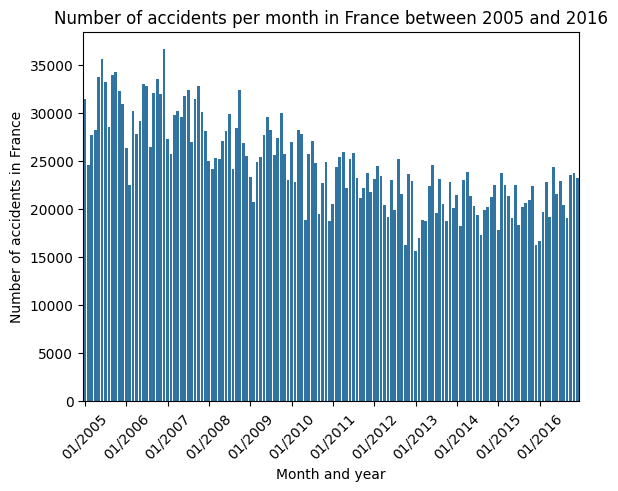

In [4]:
# We create a dataframe 'time' with only the information about the time of the accidents
time = data[['Year', 'Month']]

# We add a column 'Year-Month' containing the month and the year of the accident
time['Year-Month'] = time['Year'].astype('str') + " - " + time['Month'].astype('str')

# We plot first the number of accidents per month
plt.figure()

sns.countplot(data=time, x='Year-Month')



plt.xlabel("Month and year")

plt.ylabel("Number of accidents in France")

plt.xticks(ticks=[i for i in range(0, 144, 12)], labels=["01/"+ str(i) for i in range(2005,2017)], rotation=45)

plt.title("Number of accidents per month in France between 2005 and 2016")

plt.show()

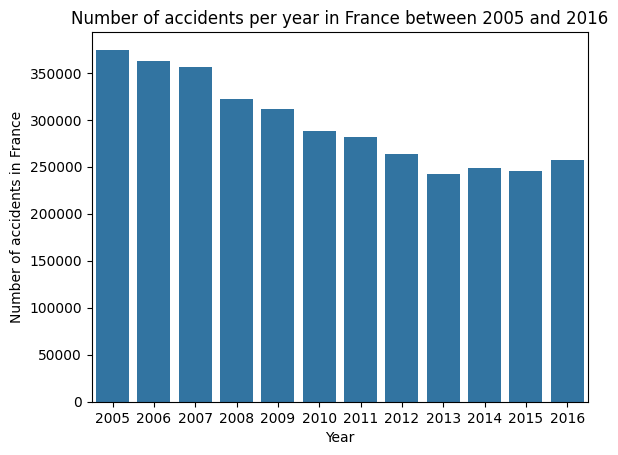

In [5]:
# We plot the number of accidents per year

plt.figure()



sns.countplot(data=time, x='Year')



plt.xticks(ticks=plt.xticks()[0], labels=range(2005,2017))

plt.ylabel("Number of accidents in France")

plt.title("Number of accidents per year in France between 2005 and 2016")

plt.show()

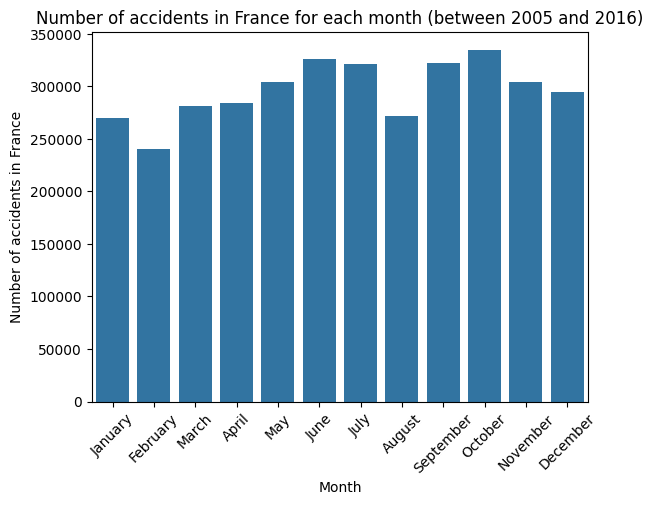

In [6]:
# We plot the number of accidents per month, no matter what the year is

plt.figure()



sns.countplot(data=time, x='Month')



plt.xticks(ticks=plt.xticks()[0], labels=['January', 'February','March','April','May','June','July','August','September','October','November',"December"], rotation=45)



plt.ylabel("Number of accidents in France")

plt.title("Number of accidents in France for each month (between 2005 and 2016)")

plt.show()

## Data Filtering

In [7]:
# Selection of the columns that we want to keep that we rename appropriately

columns = ['an', 'mois', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu', 'lum', 'atm', 'catr', 'surf']



data = initial_data[columns]

data.columns = ['Year', 'Month', 'User category', 'Severity', 'Sex', 'Year of birth', 'Trip purpose', 'Security', 'Luminosity', 'Weather', 'Type of road', 'Road surface']



# Calculate the mean of each feature (column)

means = data.mean(axis=1)



# Normalization of the data - Calculation of the standard deviation of each feature (column)

datanorm = StandardScaler().fit_transform(data)

datanorm = pd.DataFrame(datanorm, columns=['Year', 'Month', 'User category', 'Severity', 'Sex', 'Year of birth', 'Trip purpose', 'Security', 'Luminosity', 'Weather', 'Type of road', 'Road surface'])

datanorm

,Year,Month,User category,Severity,Sex,Year of birth,Trip purpose,Security,Luminosity,Weather,Type of road,Road surface
0,-1.435929,-1.678549,-0.498475,1.149756,-0.697267,0.193774,-0.757007,-0.349630,0.773626,-0.353534,-0.202657,-0.276017
1,-1.435929,-1.678549,-0.498475,1.149756,-0.697267,0.193774,-0.757007,-0.349630,0.773626,-0.353534,-0.202657,-0.276017
2,-1.435929,-1.678549,-0.498475,0.409444,1.434170,-0.254576,-0.009621,-0.349630,0.773626,-0.353534,-0.202657,-0.276017
3,-1.435929,-1.678549,-0.498475,0.409444,1.434170,-0.254576,-0.009621,-0.349630,0.773626,-0.353534,-0.202657,-0.276017
4,-1.435929,-1.678549,1.345582,-1.071180,-0.697267,-0.478751,-1.130700,-0.349630,0.773626,-0.353534,-0.202657,-0.276017
...,...,...,...,...,...,...,...,...,...,...,...,...
3553971,1.731358,1.569722,-0.498475,1.149756,-0.697267,-0.310620,-0.009621,0.223845,-0.579388,-0.353534,-1.001787,-0.276017
3553972,1.731358,1.569722,1.345582,1.149756,-0.697267,-0.310620,-1.130700,0.223845,-0.579388,-0.353534,-1.001787,-0.276017
3553973,1.731358,1.569722,1.345582,1.149756,-0.697267,-0.310620,-1.130700,0.223845,-0.579388,-0.353534,-1.001787,-0.276017
3553974,1.731358,1.569722,-0.498475,-1.071180,-0.697267,0.473993,-1.130700,-0.349630,-0.579388,-0.353534,-1.001787,-0.276017


<Axes: >

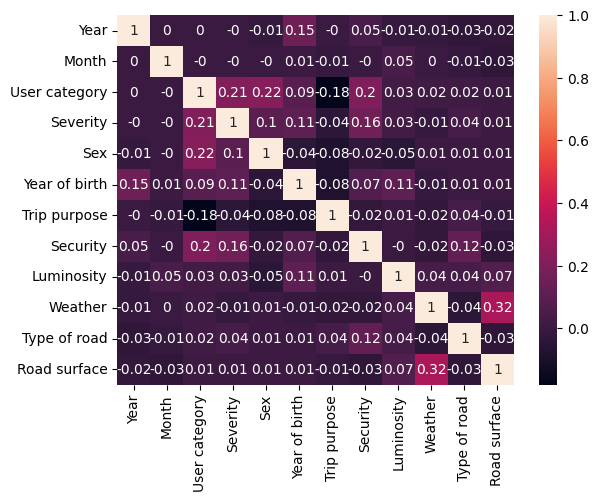

In [8]:
# Correlation matrix
sns.heatmap(datanorm.corr().round(2), annot=True)

In [9]:
# PCA

#Normalization of the data

data = data.fillna(data.mean())

X = data.to_numpy()

Xstd = StandardScaler().fit_transform(X)



pca = PCA(n_components=2)

Xpca = pca.fit_transform(Xstd)

In [10]:
ccircle = []

eucl_dist = []

for i,j in enumerate(X .T):

    corr1 = np.corrcoef(j,Xpca[:,0])[0,1]

    corr2 = np.corrcoef(j,Xpca[:,1])[0,1]

    ccircle.append((corr1, corr2))

    eucl_dist.append(np.sqrt(corr1**2 + corr2**2))

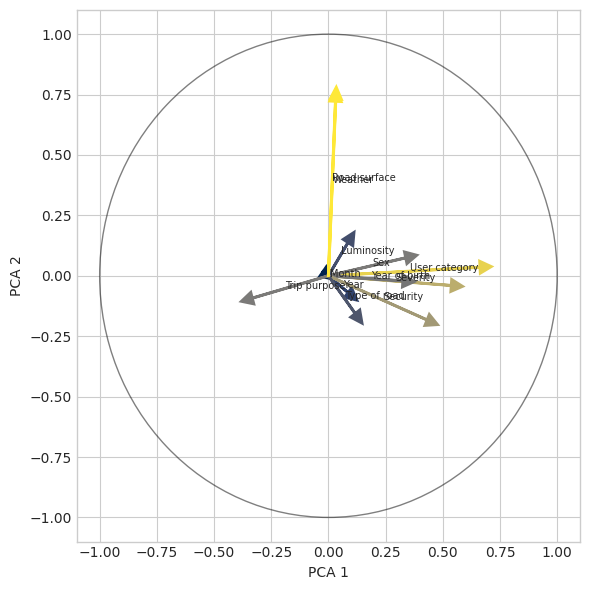

In [11]:
with plt.style.context('seaborn-v0_8-whitegrid'):

    fig, axs = plt.subplots(figsize=(6, 6))

    for i,j in enumerate(eucl_dist):

        arrow_col = plt.cm.cividis((eucl_dist[i] - np.array(eucl_dist).min())/\

                                (np.array(eucl_dist).max() - np.array(eucl_dist).min()) )

        axs.arrow(0,0, # Arrows start at the origin of the graphic

                 ccircle[i][0],  #0 for PC1

                 ccircle[i][1],  #1 for PC2

                 lw = 2, # establishment of line width

                 length_includes_head=True, 

                 color = arrow_col,

                 fc = arrow_col,

                 head_width=0.05,

                 head_length=0.05)

        # The labels of the arrows in relatively reasonable size

        axs.text(ccircle[i][0]/2,ccircle[i][1]/2, data.columns[i], fontsize=7)

    # Draw the unit circle

    circle = Circle((0, 0), 1, facecolor='none', edgecolor='k', linewidth=1, alpha=0.5)

    axs.add_patch(circle)

    axs.set_xlabel("PCA 1", fontsize=10)

    axs.set_ylabel("PCA 2", fontsize=10)



    axs.set_xlabel("PCA 1")

    axs.set_ylabel("PCA 2")

plt.tight_layout()

plt.show()

In [12]:
# Select the columns that we want to keep and we rename it appropriately

columns = ['an', 'mois', 'grav', 'lat', 'long']



data = initial_data[columns]

data.columns = ['Year', 'Month', 'Severity', 'Latitude', 'Longitude']



# Delete all rows for which we have no information about location

data.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)



# Rearrange the 'Severity' numbers in ascending order

data['Severity'].replace({2: 4, 4: 2}, inplace=True)



# Create a dictionary with a description for each level of severity

severity_description = {

    1: "Unscathed",

    2: "Light injury",

    3: "Hospitalized wounded",

    4: "Killed"

}



data.reset_index(drop=True, inplace=True)

data

,Year,Month,Severity,Latitude,Longitude
0,5,1,2,5051500.0,294400.0
1,5,1,2,5051500.0,294400.0
2,5,1,3,5051500.0,294400.0
3,5,1,3,5051500.0,294400.0
4,5,1,1,5051500.0,294400.0
...,...,...,...,...,...
1583624,16,1,2,0.0,0.0
1583625,16,1,1,0.0,0.0
1583626,16,1,2,0.0,0.0
1583627,16,1,1,0.0,0.0


In [13]:
# Replace wrong characters with '0' and convert it to double

data['Longitude'] = data['Longitude'].replace('-', 0).astype('double')

data['Latitude'] = data['Latitude'].replace('-', 0).astype('double')



# Keep only the accidents located in mainland france

data = data.loc[(data['Longitude'] < 3*10**6) & (data['Latitude'] > 3*10**6) & (data['Latitude'] < 5.2*10**6)]



data.reset_index(drop=True, inplace=True)

data

,Year,Month,Severity,Latitude,Longitude
0,5,1,2,5051500.0,294400.0
1,5,1,2,5051500.0,294400.0
2,5,1,3,5051500.0,294400.0
3,5,1,3,5051500.0,294400.0
4,5,1,1,5051500.0,294400.0
...,...,...,...,...,...
949184,16,12,2,4887110.0,241310.0
949185,16,12,1,4887110.0,241310.0
949186,16,12,1,4887110.0,241310.0
949187,16,12,2,4885850.0,241411.0


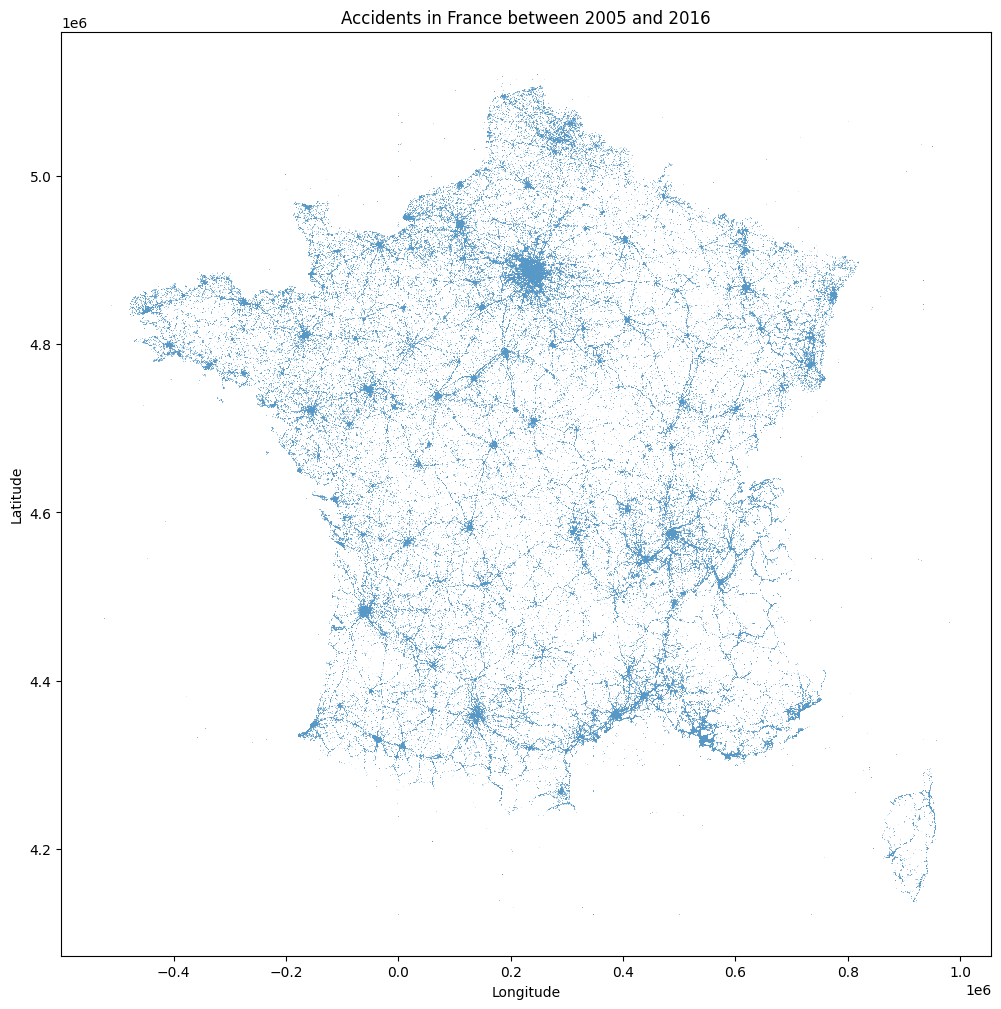

In [14]:
plt.figure(figsize=(12, 12))

sns.scatterplot(data=data, x='Longitude', y='Latitude', s=0.1)

plt.title("Accidents in France between 2005 and 2016")

plt.show()

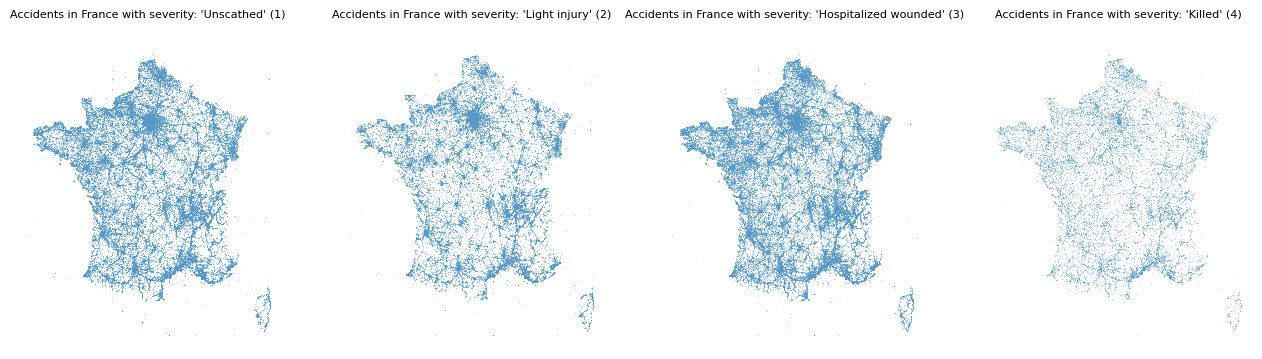

In [15]:
plt.figure(figsize=(16,4))



for i in range(1, 5):

    plt.subplot(1, 4, i)

    sns.scatterplot(data=data.loc[data['Severity']==i], x='Longitude', y='Latitude', s=0.1)

    plt.axis(False)

    plt.title(f"Accidents in France with severity: '{severity_description[i]}' ({i})", fontsize=8)

plt.show()

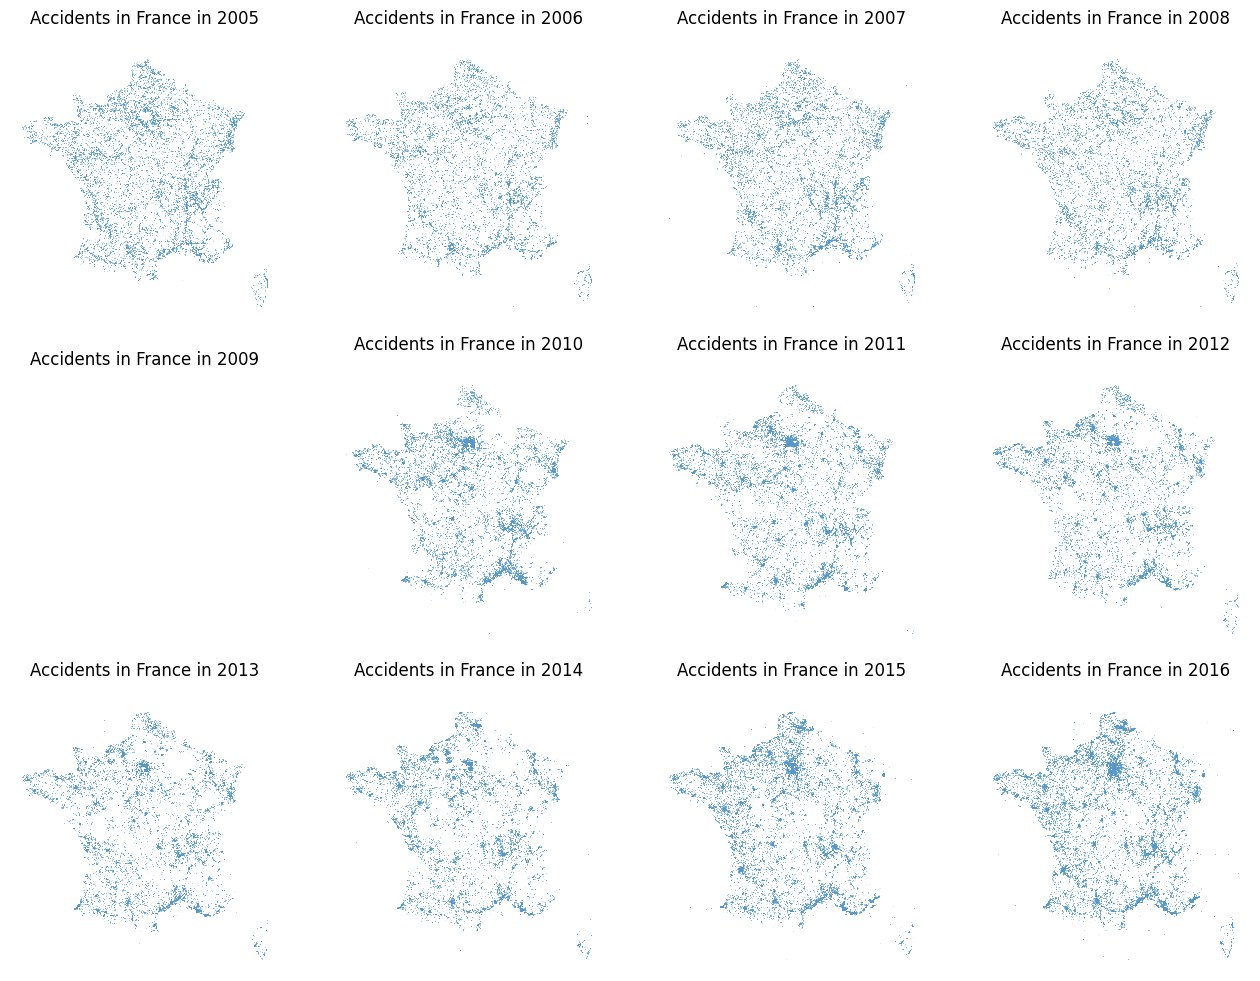

In [16]:
plt.figure(figsize=(16,12))



for i in range(1, 13):

    plt.subplot(3, 4, i)

    sns.scatterplot(data=data.loc[data['Year']==4+i], x='Longitude', y='Latitude', s=0.1)

    plt.axis(False)

    plt.title(f"Accidents in France in {2004 + i}")

plt.show()

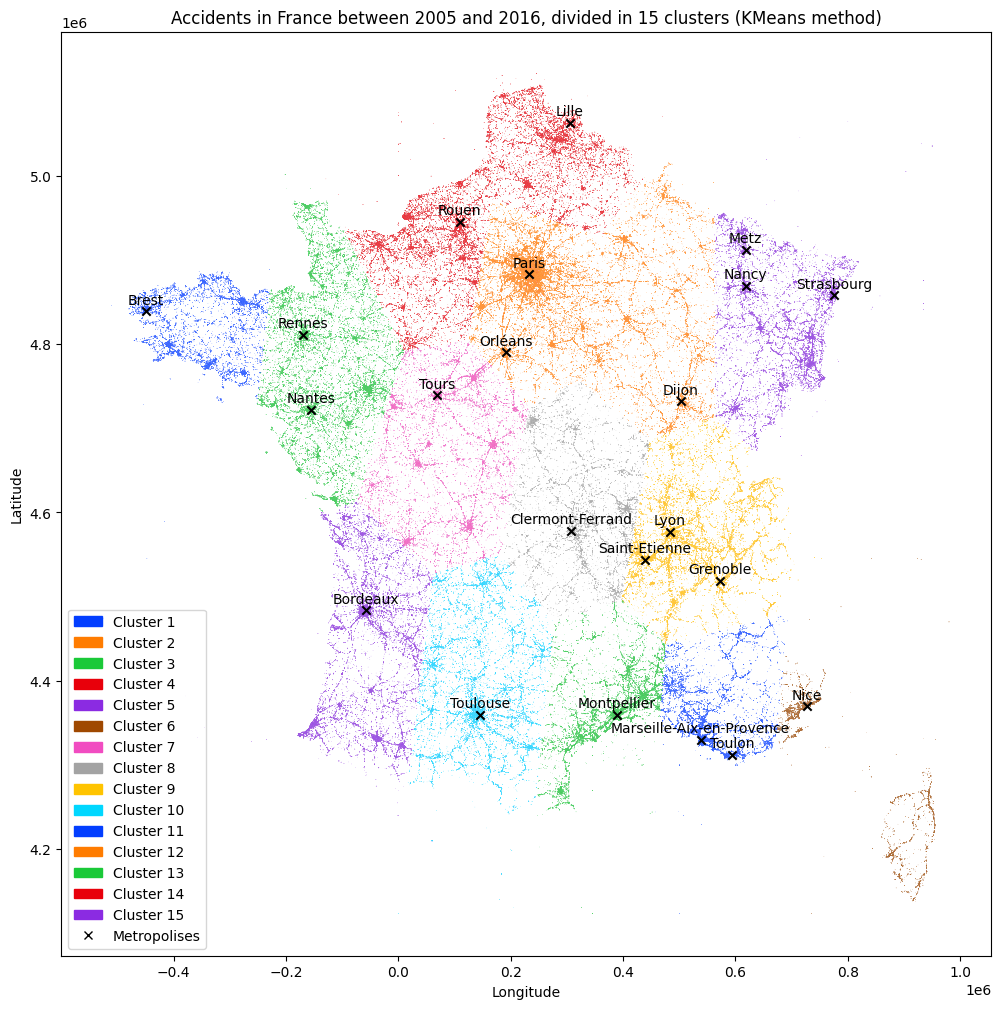

In [17]:
n_clusters = 15



# Perform KMeans clusterization

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(data[['Longitude', 'Latitude']])

labels = kmeans.labels_



# Create a figure and plot all the accidents with different colors according to the different clusters

plt.figure(figsize=(12,12))

sns.scatterplot(data=data, x="Longitude", y="Latitude", hue=labels, palette=sns.color_palette("bright", n_clusters), s=0.1)



# Define the longitude and latitude of the 22 french metropolises

metropolises_coordinates = {

    "Paris" : (2.33*10**5, 48.83*10**5),

    "Lille" : (3.05*10**5, 50.63*10**5),

    "Rouen" : (1.09*10**5, 49.45*10**5),

    "Metz" : (6.18*10**5, 49.12*10**5),

    "Nancy" : (6.18*10**5, 48.69*10**5),

    "Strasbourg" : (7.75*10**5, 48.58*10**5),

    "Brest" : (-4.49*10**5, 48.39*10**5),

    "Rennes" : (-1.69*10**5, 48.11*10**5),

    "Nantes" : (-1.56*10**5, 47.22*10**5),

    "Tours" : (0.69*10**5, 47.39*10**5),

    "Orléans" : (1.92*10**5, 47.90*10**5),

    "Dijon"  : (5.03*10**5, 47.32*10**5),

    "Clermont-Ferrand" : (3.08*10**5, 45.78*10**5),

    "Lyon" : (4.83*10**5, 45.77*10**5),

    "Saint-Etienne" : (4.39*10**5, 45.44*10**5),

    "Grenoble" : (5.73*10**5, 45.19*10**5),

    "Bordeaux" : (-0.58*10**5, 44.84*10**5),

    "Toulouse" : (1.45*10**5, 43.60*10**5),

    "Montpellier" : (3.89*10**5, 43.60*10**5),

    "Marseille-Aix-en-Provence" : (5.38*10**5, 43.30*10**5),

    "Toulon" : (5.94*10**5, 43.12*10**5),

    "Nice" : (7.27*10**5, 43.70*10**5)

}



# Add the metropolises to the plot

for city in metropolises_coordinates:

    plt.scatter(metropolises_coordinates[city][0], metropolises_coordinates[city][1], marker='x', color='black')

    plt.text(metropolises_coordinates[city][0], metropolises_coordinates[city][1] + 0.05*10**5, s=city, ha='center', va='bottom')



# Define the plot's legend

legend = []

for i, color in enumerate(sns.color_palette("bright", n_clusters)):

    legend.append(mpatches.Patch(color=color, label=f"Cluster {i + 1}"))



cross = Line2D([0], [0], label='Metropolises', marker='x', markeredgecolor='black', linestyle='')

legend.append(cross)



# Add the legend and show the result

plt.legend(handles=legend, loc='lower left')

plt.title(f"Accidents in France between 2005 and 2016, divided in {n_clusters} clusters (KMeans method)")

plt.show()

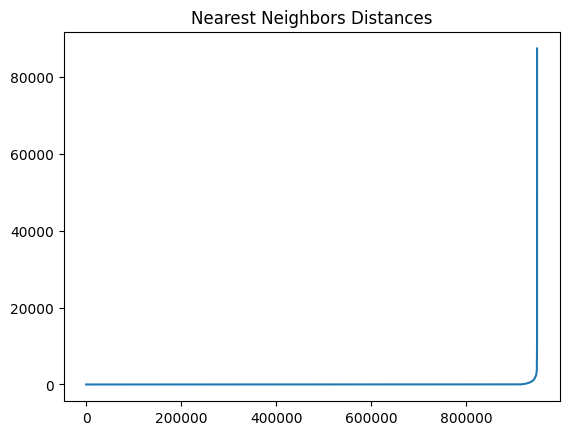

In [18]:
# Calculate the distance between each point and its nearest neighbors

neighbors = NearestNeighbors(n_neighbors=4)

neighbors_fit = neighbors.fit(data[['Longitude', 'Latitude']])

distances, indices = neighbors_fit.kneighbors(data[['Longitude', 'Latitude']])



# Sort it in ascending order

distances = np.sort(distances, axis=0)

distances = distances[:,1]



# Plot the distances

plt.figure()

plt.plot(distances, label='Distances')

plt.title("Nearest Neighbors Distances")

plt.show()

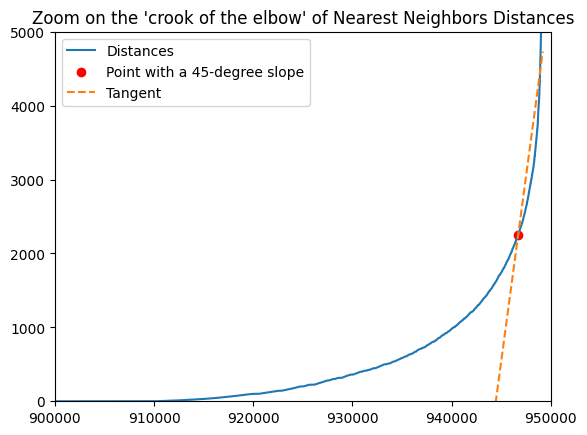

Optimal Epsilon value: 2249.2380932217916


In [19]:
# Plot the distances

plt.figure()

plt.plot(distances, label='Distances')



# We find the point of maximum curvature and calculate the tangent

point_index = np.argmin(np.abs(np.gradient(distances) - 1))

tangent_line = np.arange(len(distances)) - (point_index - distances[point_index])



# We plot the point and the tangent

plt.scatter(point_index, distances[point_index], color='red', label='Point with a 45-degree slope')

plt.plot(tangent_line, label=f'Tangent', linestyle='--')



# Zoom on the crook of the elbow

plt.legend()

plt.axis([900000, 950000, 0, 5000])

plt.title("Zoom on the 'crook of the elbow' of Nearest Neighbors Distances")

plt.show()



# Print the espilon value found

print(f"Optimal Epsilon value: {distances[point_index]}")

In [20]:
# Perform DBBSCAN clusterization method

db = DBSCAN(eps=2250, min_samples=300).fit(data[['Longitude', 'Latitude']])

labels = db.labels_



# Count and print the number of clusters

n_clusters = len(set(labels)) - 1

print(f"{n_clusters} clusters found.")

153 clusters found.


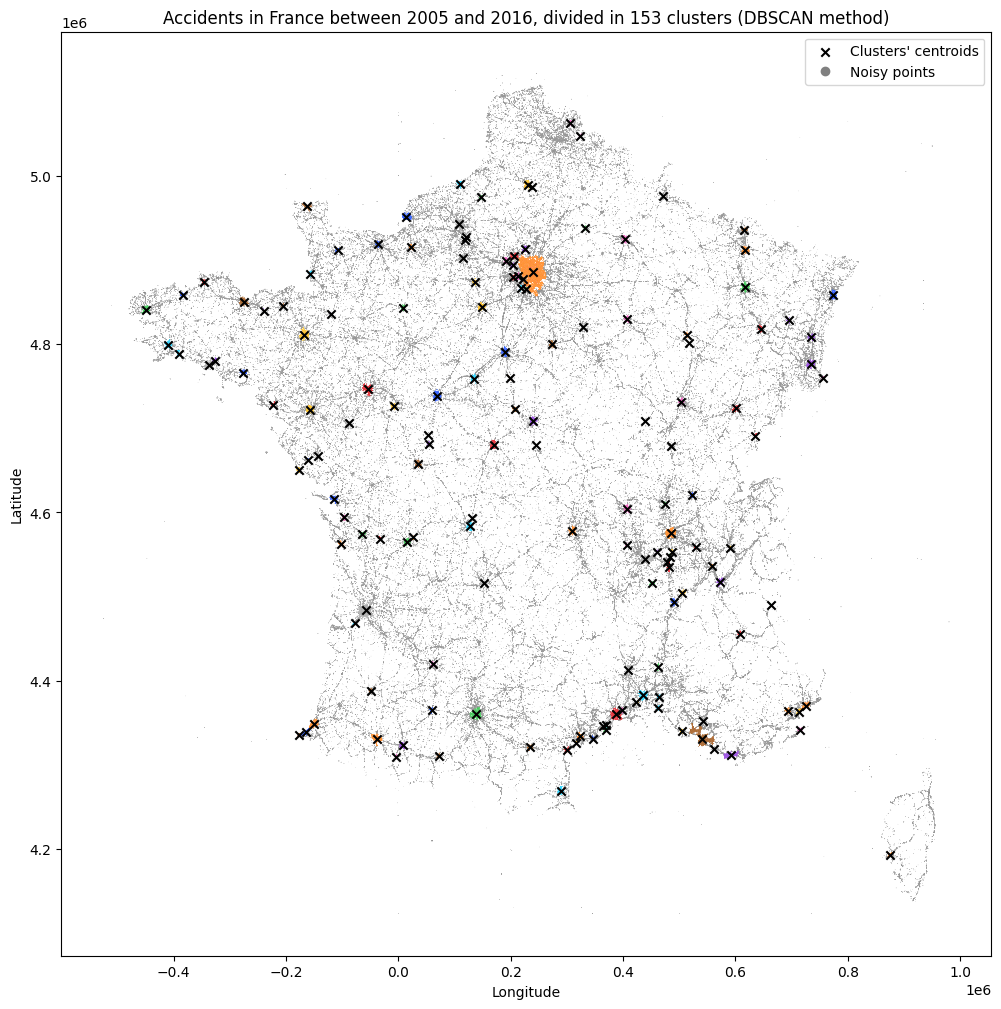

In [21]:
plt.figure(figsize=(12, 12))



# Create a custom palette where each cluster have a bright color, and unclassified points are gray

custom_palette = {}

palette = sns.color_palette('bright', n_clusters)



k=0

for cluster in set(labels):

    if cluster != -1:

        custom_palette[cluster] = palette[k]

        k+=1

    else:

        custom_palette[cluster] = (0.5, 0.5, 0.5)



# Create a column 'Cluster' with the corresponding cluster for each point

data['Cluster'] = labels



# Plot all the accidents with different colors using the custom palette

scatter = sns.scatterplot(data=data, x="Longitude", y="Latitude", hue='Cluster', palette=custom_palette, s=0.1, legend=None)



# Plot a marker on the centroids of each cluster

centroids = data.groupby('Cluster')[['Longitude', 'Latitude']].mean()

plt.scatter(centroids['Longitude'], centroids['Latitude'], marker='x', color='black', label="Clusters' centroids")



# Add noisy points to the figure's legend

legend, _ = scatter.get_legend_handles_labels()

point = Line2D([0], [0], label='Noisy points', marker='o', markerfacecolor='gray', markeredgecolor='gray', linestyle='')

legend.append(point)



# Show the legend and display the figure

plt.legend(handles=legend, loc='upper right')

plt.title(f"Accidents in France between 2005 and 2016, divided in {n_clusters} clusters (DBSCAN method)")

plt.show()

In [22]:
# Select the columns that we want to keep and we rename it appropriately

columns = ['catu', 'sexe', 'an_nais', 'secu', 'lum', 'atm', 'catr', 'surf', 'grav']



data = initial_data[columns]

data.columns = ['User category', 'Sex', 'Year of birth', 'Security', 'Luminosity', 'Weather', 'Type of road', 'Road surface', 'Severity']



# Delete all rows for which one or more column is empty (NA)

data.dropna(axis=0, inplace=True)



# Rearrange the 'Severity' numbers in ascending order

data['Severity'].replace({2: 4, 4: 2}, inplace=True)



data.reset_index(drop=True, inplace=True)

data

,User category,Sex,Year of birth,Security,Luminosity,Weather,Type of road,Road surface,Severity
0,1,1,1976.0,11.0,3,1.0,3.0,1.0,2
1,1,1,1976.0,11.0,3,1.0,3.0,1.0,2
2,1,2,1968.0,11.0,3,1.0,3.0,1.0,3
3,1,2,1968.0,11.0,3,1.0,3.0,1.0,3
4,2,1,1964.0,11.0,3,1.0,3.0,1.0,1
...,...,...,...,...,...,...,...,...,...
3499067,1,1,1967.0,21.0,1,1.0,2.0,1.0,2
3499068,2,1,1967.0,21.0,1,1.0,2.0,1.0,2
3499069,2,1,1967.0,21.0,1,1.0,2.0,1.0,2
3499070,1,1,1981.0,11.0,1,1.0,2.0,1.0,1


In [23]:
X = data.drop(columns='Severity').copy()

y = data[['Severity']].copy()



X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.40, random_state=1234)



print(X_train.shape, X_test.shape)

(2099443, 8) (1399629, 8)


Name   Accuracy  Precision  Recall  F1_score
--------------------------------------------
Logit    0.491     0.433     0.491    0.414
NBayes   0.478     0.434     0.478    0.413
LDA      0.493     0.458     0.493    0.415
QDA      0.478     0.444     0.478    0.417


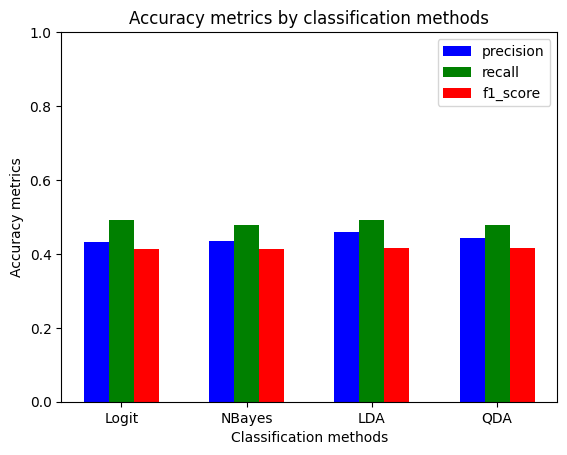

In [24]:
# Define the names of the classifications method

names = ["Logit", "NBayes", "LDA", "QDA"]



# Define the classifiers

classifiers = [LogisticRegression(C=1e5),

               GaussianNB(), 

               DA.LinearDiscriminantAnalysis(),

               DA.QuadraticDiscriminantAnalysis()

]



# Write the head line of the table describing the accuracy of each method

print('Name   Accuracy  Precision  Recall  F1_score\n'+44*'-')



# Create a new figure for the histogram

plt.figure()



# Loop through all different classfication methods

for name, clf in zip(names, classifiers):



    # Predict the diagnosis using the classifier

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    

    # Calculate the accuracy metrics

    accuracy = accuracy_score(y_test,y_pred)

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    

    # Print the classifier's name and its accuracy score

    print('{:6} {:7.3f} {:9.3f} {:9.3f} {:8.3f}'.format(name, accuracy, precision, recall, f1_score))



    # Create a bar in the histogram for each accuracy metrics

    plt.bar(names.index(name) - 0.2, precision, color='blue', width=0.2)

    plt.bar(names.index(name), recall, color='g', width=0.2)

    plt.bar(names.index(name) + 0.2, f1_score, color='r', width=0.2)



# Write the classification methods' names on the x axis

plt.xticks(range(len(names)), names)



# Add a xlabel, ylabel and title to the plot

plt.xlabel("Classification methods")

plt.ylabel("Accuracy metrics")

plt.title("Accuracy metrics by classification methods")



# Add the legend to the plot

plt.legend(["precision", "recall", "f1_score"])



# Increase the size of the plot so that the legend does not hide the metrics of the latest classification method.

plt.ylim(top=1)



# Show the plot

plt.show()